# Time-domain Granger Causality
## Pairwise Granger Causality
The Granger causality is a method to determine functional connectivity between time-series using autoregressive modelling. In the simpliest pairwise Granger causality case for signals X and Y the data are modelled as autoregressive processes. Each of these processes has two representations. The first representation contains the history of the signal X itself and a prediction error (or noise a.k.a. residual), whereas the second also incorporates the history of the other signal. 

If inclusion of the history of Y next to the history of X into X model reduces the prediction error compared to just the history of X alone, Y is said to Granger cause X. The same can be done by interchanging the signals to determine if X Granger causes Y.

## Conditional Granger Causality
Conditional Granger causality can be used to further investigate this functional connectivity. Given signals X, Y and Z, we find that Y Granger causes X, but we want to test if this causality is mediated through Z. We can use Z as a condition for the aforementioned Granger causality.

In order to illustrate the function of time-domain Granger causality we will be using examples from Ding et al. (2006) chapter. Specifically, we will have two cases of three signals. In the first case we will have indirect connectivity only, whereas in the second case both direct and indirect connectivities will be present.

References: Ding M., Chen Y. and Bressler S.L. (2006) Granger Causality: Basic Theory and Application to Neuroscience. https://arxiv.org/abs/q-bio/0608035



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from elephant.causality.granger import pairwise_granger, conditional_granger

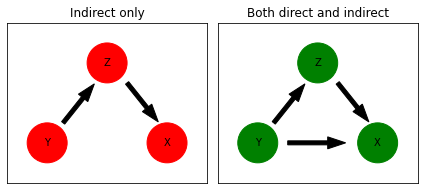

In [2]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
# Indirect causal influence diagram
node1 = plt.Circle((0.2, 0.2), 0.1, color='red')
node2 = plt.Circle((0.5, 0.6), 0.1, color='red')
node3 = plt.Circle((0.8, 0.2), 0.1, color='red')
ax1.set_aspect(1)
ax1.arrow(0.28, 0.3, 0.1, 0.125, width=0.02, color='k')
ax1.arrow(0.6, 0.5, 0.1, -0.125, width=0.02, color='k')
ax1.add_artist(node1)
ax1.add_artist(node2)
ax1.add_artist(node3)
ax1.text(0.2, 0.2, 'Y', horizontalalignment='center', verticalalignment='center')
ax1.text(0.5, 0.6, 'Z', horizontalalignment='center', verticalalignment='center')
ax1.text(0.8, 0.2, 'X', horizontalalignment='center', verticalalignment='center')
ax1.set_title('Indirect only')
ax1.set_xbound((0, 1))
ax1.set_ybound((0, 0.8))

ax1.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, 
                right=False, left=False, labelleft=False)

# Both direct and indirect causal influence diagram
node1 = plt.Circle((0.2, 0.2), 0.1, color='g')
node2 = plt.Circle((0.5, 0.6), 0.1, color='g')
node3 = plt.Circle((0.8, 0.2), 0.1, color='g')
ax2.set_aspect(1)
ax2.arrow(0.28, 0.3, 0.1, 0.125, width=0.02, color='k')
ax2.arrow(0.35, 0.2, 0.2, 0.0, width=0.02, color='k')
ax2.arrow(0.6, 0.5, 0.1, -0.125, width=0.02, color='k')
ax2.add_artist(node1)
ax2.add_artist(node2)
ax2.add_artist(node3)
ax2.text(0.2, 0.2, 'Y', horizontalalignment='center', verticalalignment='center')
ax2.text(0.5, 0.6, 'Z', horizontalalignment='center', verticalalignment='center')
ax2.text(0.8, 0.2, 'X', horizontalalignment='center', verticalalignment='center')
ax2.set_xbound((0, 1))
ax2.set_ybound((0, 0.8))

ax2.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, 
                right=False, left=False, labelleft=False)
ax2.set_title('Both direct and indirect')
plt.tight_layout()
plt.show()

In [8]:
def generate_data(length=30000, causality_type="indirect"):
    """
    Recreated from Example 2 section 5.2 of :cite:'granger-Ding06-0608035'.
    
    Parameters
    ----------
    length : int
        The length of the signals to be generated (i.e. shape(signal) = (3, length))
    causality_type: str
        Type of causal influence in the data:
            'indirect' for indirect causal influence only (i.e. Y -> Z -> X)
            'both' for direct and indirect causal influence
    
    
    Notes
    -----
    Taken from elephant.test.test_causality.ConditionalGrangerTestCase

    """
    if causality_type == "indirect":
        y_t_lag_2 = 0
    elif causality_type == "both":
        y_t_lag_2 = 0.2
    else:
        raise ValueError("causality_type should be either 'indirect' or "
                         "'both'")

    order = 2
    signal = np.zeros((3, length + order))

    weights_1 = np.array([[0.8, 0, 0.4],
                          [0, 0.9, 0],
                          [0., 0.5, 0.5]])

    weights_2 = np.array([[-0.5, y_t_lag_2, 0.],
                          [0., -0.8, 0],
                          [0, 0, -0.2]])

    weights = np.stack((weights_1, weights_2))

    noise_covariance = np.array([[0.3, 0.0, 0.0],
                                 [0.0, 1., 0.0],
                                 [0.0, 0.0, 0.2]])

    for i in range(length):
        for lag in range(order):
            signal[:, i + order] += np.dot(weights[lag],
                                           signal[:, i + 1 - lag])
        rnd_var = np.random.multivariate_normal([0, 0, 0],
                                                noise_covariance)
        signal[:, i + order] += rnd_var

    signal = signal[:, 2:]

    return signal.T

# Indirect causality

In [10]:
np.random.seed(1)

# Indirect causality
xyz_indirect_sig = generate_data(length=10000, causality_type='indirect')
xy_indirect_sig = xyz_indirect_sig[:, :2]
indirect_pairwise_gc = pairwise_granger(xy_indirect_sig, max_order=10, information_criterion='aic')
print(indirect_pairwise_gc)

Causality(directional_causality_x_y=0.0, directional_causality_y_x=0.4, instantaneous_causality=0.0, total_interdependence=0.4)


In [5]:
# Indirect causality (conditioned on z)
indirect_cond_gc = conditional_granger(xyz_indirect_sig, max_order=10, information_criterion='aic')
print(indirect_cond_gc)
print('Zero value indicates total dependence on signal Z')

0.0
Zero value indicates total dependence on signal Z


# Both direct and indirect causality

In [6]:
# Both direct and indirect causality
xyz_both_sig = generate_data(length=10000, causality_type='both')
xy_both_sig = xyz_both_sig[:, :2]
both_pairwise_gc = pairwise_granger(xy_both_sig, max_order=10, information_criterion='aic')
print(both_pairwise_gc)

Causality(directional_causality_x_y=0.0, directional_causality_y_x=0.73, instantaneous_causality=0.0, total_interdependence=0.73)


In [7]:
# Both direct and indirect causality (conditioned on z)
both_cond_gc = conditional_granger(xyz_both_sig, max_order=10, information_criterion='aic')
print(both_cond_gc)
print('Non-zero value indicates the presence of direct Y to X influence')

0.08
Non-zero value indicates the presence of direct Y to X influence
